In [71]:
import numpy as np
from the_collector import BagIt, Pickle
from matplotlib import pyplot as plt

import cv2

from colorama import Fore

In [2]:
def info(bag):
    print('Bag keys:')
    print('-'*50)
    for k in bag.keys():
        print(f'  {k:>10}: {len(bag[k]):<7}')
        
def plot3(t, data,title):
    x = [x[0] for x in data]
    y = [x[1] for x in data]
    z = [x[2] for x in data]
    plt.plot(t,x,label='x')
    plt.plot(t,y,label='y')
    plt.plot(t,z,label='z')
    plt.title(title)
    plt.legend()
    plt.grid(True);

In [3]:
bagfile = "../path-data/test-simple.pickle.bag"
bag = BagIt(Pickle)
data = bag.read(bagfile)
info(data)

>> Reading[pickle]: ../path-data/test-simple.pickle.bag
Bag keys:
--------------------------------------------------
         imu: 1420   
      camera: 1413   


In [4]:
accel = np.array([x[0] for x in data["imu"]])
gyro = np.array([x[1] for x in data["imu"]])
mag = np.array([x[2] for x in data["imu"]])

start = data["imu"][0][3]
t = np.array([x[3]-start for x in data["imu"]])

In [170]:
def featureDetection():
    thresh = dict(threshold=25, nonmaxSuppression=True);
    fast = cv2.FastFeatureDetector_create(**thresh)
    return fast

def getAbsoluteScale(f0, f1):
    x_pre, y_pre, z_pre = f0
    x    , y    , z     = f1
    scale = np.sqrt((x-x_pre)**2 + (y-y_pre)**2 + (z-z_pre)**2)
    return x, y, z, scale

def featureTracking(img_1, img_2, p1):
    w = 33
    win = (w,w)
    lk_params = dict( winSize  = win,
                      maxLevel = 3,
                      criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))

    p2, st, err = cv2.calcOpticalFlowPyrLK(img_1, img_2, p1, None, **lk_params)
#     print(err)
    st = st.reshape(st.shape[0])
    ##find good one
    p1 = p1[st==1]
    p2 = p2[st==1]

    return p1,p2

In [193]:
def run(images):
    img_1 = images[0]
    img_2 = images[0]

    if len(img_1) == 3:
        gray_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
        gray_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)
    else:
        gray_1 = img_1
        gray_2 = img_2

    # find the detector
    detector = featureDetection()
    kp1      = detector.detect(img_1)
    p1       = np.array([kp.pt for kp in kp1],dtype='float32')
    p1, p2   = featureTracking(gray_1, gray_2, p1)

    # Camera parameters
    fc = 3.04/(1.12*1e-3) # mm/(mm/px) -> px
    px = 320/2
    py = 240/2
    pp = (px,py)
    K  = np.array([
            [fc, 0, px],
            [0, fc, py],
            [0, 0, 1]])

#     E, mask = cv2.findEssentialMat(p2, p1, fc, pp, cv2.RANSAC,0.999,1.0);
#     _, R, t, mask = cv2.recoverPose(E, p2, p1,focal=fc, pp = pp);

    # initialize some parameters
    MAX_FRAME     = 300 #len(images)
    MIN_NUM_FEAT  = 30

    preFeature = p2
    preImage   = gray_2

    R_f = np.eye(3) #R
    t_f = np.array([0,0,0]) #t
    print(R_f,t_f)

    maxError = 0
    ret_pos = []
    
    for numFrame in range(2, MAX_FRAME):

        if numFrame % 20 == 0:
            print(numFrame)

        if (len(preFeature) < MIN_NUM_FEAT):
            feature   = detector.detect(preImage)
            preFeature = np.array([ele.pt for ele in feature],dtype='float32')
            print(f"{Fore.RED}Found new features: {preFeature.shape[0]}{Fore.RESET}")

        curImage_c = images[numFrame]

        if len(curImage_c) == 3:
              curImage = cv2.cvtColor(currImage_c, cv2.COLOR_BGR2GRAY)
        else:
              curImage = curImage_c

        kp1 = detector.detect(curImage);
        preFeature, curFeature = featureTracking(preImage, curImage, preFeature)
        E, mask = cv2.findEssentialMat(curFeature, preFeature, fc, pp, cv2.RANSAC,0.999,1.0);
        _, R, t, mask = cv2.recoverPose(E, curFeature, preFeature, focal=fc, pp = pp)
        t = t.T[0]

#         truth_x, truth_y, truth_z, absolute_scale = getAbsoluteScale(
#             ground_truth[numFrame-1], ground_truth[numFrame])
        
#         if numFrame % 20 == 0:
#             print('scale', absolute_scale)

        absolute_scale = 1.0
            
        if absolute_scale > 0.1:
            R_f = R_f.dot(R)
            t_f = t_f + absolute_scale*R_f.dot(t)
#             R_f = R.dot(R_f)
#             R_f = R_f.dot(R)
        else:
            print("crap ... bad scale:", absolute_scale)

        preImage = curImage
        preFeature = curFeature

        ret_pos.append(t_f)

    return ret_pos

In [194]:
imgs = [x[0] for x in data["camera"]]
tc   = [x[1] for x in data["camera"]]

In [195]:
pts = np.array(run(imgs))

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [0 0 0]
20
40
60
80
100
120
140
160
180
200
220
240
260
280


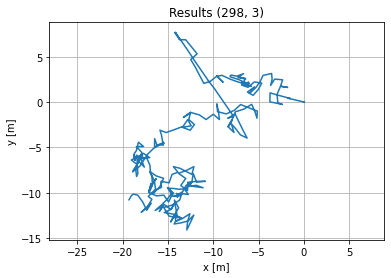

In [196]:
plt.plot(pts[:,0], pts[:,1], label='Odometry')
plt.title(f'Results {pts.shape}')
plt.grid(True)
plt.axis('equal')
plt.xlabel('x [m]')
plt.ylabel('y [m]');

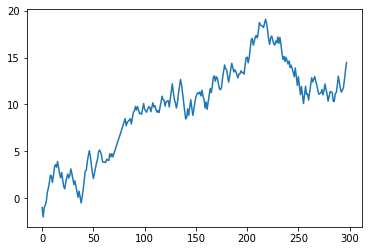

In [192]:
plt.plot(pts[:,2])

In [169]:
help(cv2.calcOpticalFlowPyrLK)

Help on built-in function calcOpticalFlowPyrLK:

calcOpticalFlowPyrLK(...)
    calcOpticalFlowPyrLK(prevImg, nextImg, prevPts, nextPts[, status[, err[, winSize[, maxLevel[, criteria[, flags[, minEigThreshold]]]]]]]) -> nextPts, status, err
    .   @brief Calculates an optical flow for a sparse feature set using the iterative Lucas-Kanade method with
    .   pyramids.
    .   
    .   @param prevImg first 8-bit input image or pyramid constructed by buildOpticalFlowPyramid.
    .   @param nextImg second input image or pyramid of the same size and the same type as prevImg.
    .   @param prevPts vector of 2D points for which the flow needs to be found; point coordinates must be
    .   single-precision floating-point numbers.
    .   @param nextPts output vector of 2D points (with single-precision floating-point coordinates)
    .   containing the calculated new positions of input features in the second image; when
    .   OPTFLOW_USE_INITIAL_FLOW flag is passed, the vector must have the 

In [197]:
320*240*2

153600

In [198]:
640*480

307200